In [ ]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import Dataset
from torchvision import transforms as T

from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Colab Notebooks/COMP447/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1.1 Basics of Autograd (5 points)

a. In the provided notebook, fill in the function sin_taylor() with code to
approximate the value of the sine function using the Taylor approximation
(defined here). You can use numpy.math.factorial()to help you.

In [ ]:
"""
Taylor approximation to sin(x).
x: (float) Input value
n: (int) Number of terms in Taylor approximation
"""
def sin_taylor(x, n=10):
  sum = 0.0
  for i in range(n):
    if i % 2 == 0:
      continue
    else:
      term1 = (-1) ** ((i - 1) / 2) * x ** i
      term2 = np.math.factorial(i)
      sum += term1 / term2
  return sum

b. Create a tensor x with value 𝜋/4 . Make sure to set require gradients on x (see
this page). Create a new tensor y = sin_taylor(x). Use y.backward() to
evaluate the gradient of y at x. Is this value a close approximation to the exact
derivative of sine at x?

In [ ]:
x = torch.tensor([np.pi/4], requires_grad=True, device='cuda')
y = sin_taylor(x)
y.backward()
print(x.grad)

tensor([0.7071], device='cuda:0')


<ipython-input-9-d553cd291695>:13: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  term2 = np.math.factorial(i)


c. Now, create a NumPy array x_npy of 100 random numbers drawn uniformly
from [−𝜋, 𝜋] (use np.random.uniform). Create a tensor x from that array and
place the tensor onto the GPU. Again, evaluate y = sin_taylor(x). This
time, y is a vector. If you run y.backward(), it will throw an error because
autograd is meant to evaluate the derivative of a scalar output with respect to
input vectors (see tutorial pages above). Instead, run either one of these two
lines (they do the same thing):
y.sum().backward()
y.backward(gradient=torch.ones(100).to(‘cuda’))

In [ ]:
x_npy = np.random.uniform(-np.pi, np.pi, size=(100,))
x = torch.tensor(x_npy, requires_grad=True, device='cuda')
y = sin_taylor(x)
y.sum().backward()

<ipython-input-9-d553cd291695>:13: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  term2 = np.math.factorial(i)


d. Get the gradient tensor dz/dx and convert that tensor to a Numpy array. Plot
dz/dx vs. x_npy, overlaid on a cosine curve. Confirm that the points fall on the
curve and put this plot in your report.

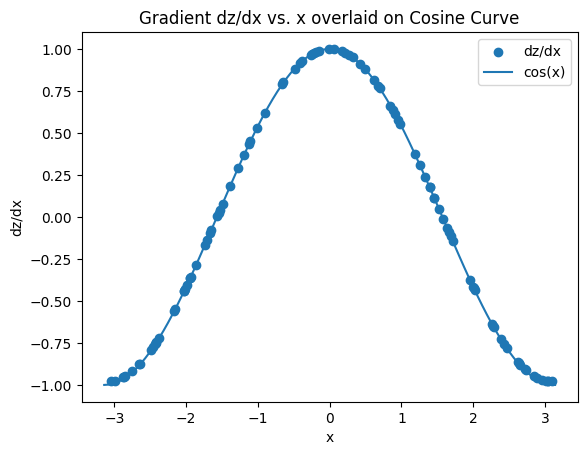

In [ ]:
dz_dx = x.grad.cpu().numpy()

x_cos = np.linspace(-np.pi, np.pi, 100)
cos_curve = np.cos(x_cos)

# Plot dz/dx vs. x_npy overlaid on cosine curve
plt.scatter(x_npy, dz_dx, label='dz/dx')
plt.plot(x_cos, cos_curve, label='cos(x)')
plt.xlabel('x')
plt.ylabel('dz/dx')
plt.title('Gradient dz/dx vs. x overlaid on Cosine Curve')
plt.legend()
plt.show()

# 1.2 Image Denoising (5 points)

a. In your Colab notebook, implement denoising_loss() to compute the
following loss function

In [ ]:
"""
Returns the x and y gradient images for input image I.
Input:
I: (Tensor) Image of shape (H, W, 3)

Output:
(Ix, Iy): (Tensor) Gradient images each of shape (H, W, 3)
"""
def get_spatial_gradients(I):
  I = I.permute(2, 0, 1).unsqueeze(0) # Change I's shape from (H, W, 3) to (1, 3, H, W)
  kx = torch.zeros(I.shape[1], I.shape[1], 3, 3).to(I.device)
  ky = torch.zeros(I.shape[1], I.shape[1], 3, 3).to(I.device)

  for i in range(3):
    kx[i, i, 1, 1] = -1
    kx[i, i, 1, 2] = 1
    ky[i, i, 1, 1] = -1
    ky[i, i, 2, 1] = 1

  Ix = F.conv2d(I, kx, padding=1)
  Iy = F.conv2d(I, ky, padding=1)
  return Ix[0,...].permute(1,2,0), Iy[0,...].permute(1,2,0)

"""
Denoising objective function.
Input:
I, J: (Tensor) Images of shape (H, W, 3)
alpha: (float) Regularization hyperparameter

Output:
loss: (float)
"""
def denoising_loss(I, J, alpha):
  data_term = torch.sum(torch.abs(I - J))
  Jx, Jy = get_spatial_gradients(J)
  regularizer = torch.sum(torch.abs(Jx)) + torch.sum(torch.abs(Jy))
  return data_term + alpha * regularizer

b. Implement gradient descent to optimize the pixels of J using your loss function
and autograd. Initialize J to be a copy of I. Try different values for the learning
rate and 𝛼 and find a combination that does a good job. Put the smoothed image
J, along with the learning rate and 𝛼 you used in your report.

<ipython-input-27-a243c2242d7b>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(path + 'parrot_noisy.png')/255.0


<Figure size 640x480 with 0 Axes>

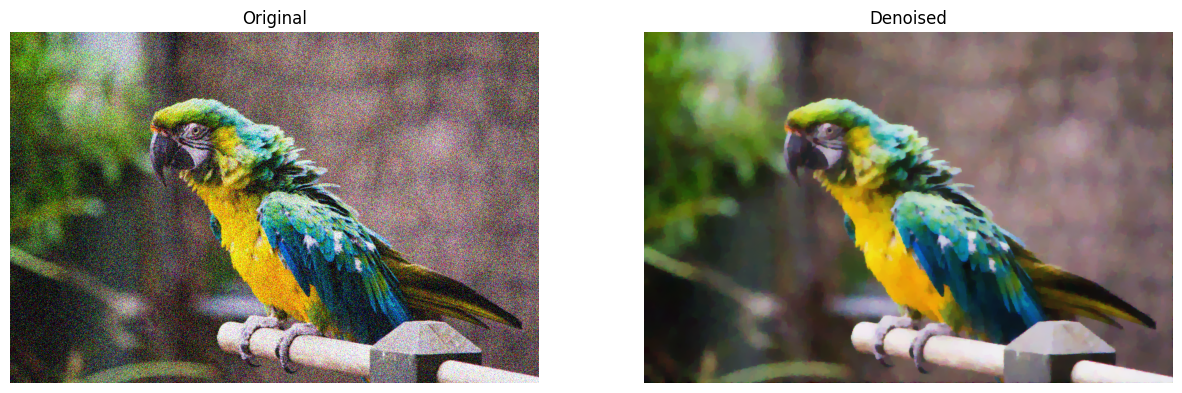

In [ ]:
img = imageio.imread(path + 'parrot_noisy.png')/255.0
I = torch.tensor(img, dtype=torch.float32)
I = I.to('cuda')
J = I.clone().requires_grad_(True)

lr = 1.0 # Learning rate
alpha = 1.3 # alpha
n_iter = 1000 # Number of iterations

for i in range(n_iter):
  loss = denoising_loss(I, J, alpha)
  loss.backward()
  # Normalize the gradient
  grad = J.grad / torch.norm(J.grad)
  with torch.no_grad():
    J -= lr * grad
  J.grad.zero_()

J = J.detach().cpu( ).numpy()
I = I.detach().cpu().numpy()

# Plot
plt.figure()
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
images = [I, J]
titles = ['Original', 'Denoised']
for i in range(2):
  ax[i].imshow(images[i])
  ax[i].axis('off')
  ax[i].set_title(f"{titles[i]}")

# 2.0 Training an image classifier (10 points)

a. Finish implementing the CIFARDataset class. See comments in the code for
further instructions.

In [ ]:
class CIFARDataset(Dataset):
  def __init__(self, images, labels, mode, transform):
    self.transform = transform

    if mode == 'train':
      self.images = images[:40000]
      self.labels = labels[:40000]

    elif mode == 'val':
      self.images = images[40000:50000]
      self.labels = labels[40000:50000]

    elif mode == 'test':
      self.images = images[50000:]
      self.labels = labels[50000:]

    else:
      raise ValueError('Invalid mode!')

  def __getitem__(self, idx):
    # Do the following:
    # 1. Get the image and label from the dataset corresponding to index idx.
    # 2. Convert the label to a LongTensor (needs to be of this type because it
    # is an integer value and PyTorch will throw an error otherwise)
    # 3. Transform the image using self.transform. This will convert the image
    # into a tensor, scale it to [0,1], and apply data augmentations.
    # 4. Return the image and label.
    image = self.images[idx]
    label = self.labels[idx]

    label = torch.tensor(label, dtype=torch.long)
    # Sanity check
    if self.transform is not None:
      image = self.transform(image)
    return image, label

  def __len__(self):
    return len(self.images)

b. Add transforms: RandomHorizontalFlip, RandomAffine ([-5, 5] degree
range, [0.8, 1.2] scale range) and ColorJitter ([0.8, 1.2] brightness range,
[0.8, 1.2] saturation range). Don’t forget to apply the ToTensor transform first,
which converts a H x W x 3 image to a 3 x H x W tensor, and normalizes the
pixel range to [0,1]. You will find the transform APIs on this page.

In [ ]:
train_transform = T.Compose([
    T.ToTensor(),  # Convert numpy array to PIL image
    T.RandomHorizontalFlip(),
    T.RandomAffine(degrees=(-5, 5), scale=(0.8, 1.2)),
    T.ColorJitter(brightness=(0.8, 1.2), saturation=(0.8, 1.2))
])

val_transform = T.Compose([
    T.ToTensor()
])

test_transform = T.Compose([
    T.ToTensor()
])

In [ ]:
cifar = np.load(path + 'CIFAR.npz')
X,y,label_names = cifar['X'], cifar['y']*1.0, cifar['label_names']
print("Read in CIFAR10 dataset with %d examples, and labels:\n %s" % (X.shape[0], label_names))

batch_size = 64

train_dataset = CIFARDataset(X, y, "train", transform=train_transform)
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

val_dataset = CIFARDataset(X, y, "val", transform=val_transform)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

test_dataset = CIFARDataset(X, y, "test", transform=test_transform)
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

Read in CIFAR10 dataset with 60000 examples, and labels:
 ['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


c. Implement a CNN classifier with the structure in the following table. You will find
the APIs for various neural network layers on this page. The spatial dimensions
of an image should NOT change after a Conv operation (only after pooling).

In [ ]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=50, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=50, out_channels=100, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(in_channels=100, out_channels=100, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(in_channels=100, out_channels=100, kernel_size=3, padding=1)

    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    self.linear1 = nn.Linear(100 * 4 * 4, 100)
    self.linear2 = nn.Linear(100, 10)

    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.conv1(x))
    x = self.maxpool(x)
    x = self.relu(self.conv2(x))
    x = self.maxpool(x)
    x = self.relu(self.conv3(x))
    x = self.maxpool(x)
    x = self.relu(self.conv4(x))

    x = x.reshape(-1, 100 * 4 * 4)
    x = self.linear1(x)
    x = self.relu(x)
    x = self.linear2(x)
    return x

d. Implement the training loop.

In [ ]:
learning_rate = 1e-4
batch_size = 64
epochs = 15
model = Model()
model.to('cuda')

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

val_loss = []

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        # Putting both of X and y to GPU
        X = X.to('cuda')
        y = y.to('cuda')
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to('cuda')
            y = y.to('cuda')
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    val_loss.append(test_loss)
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

e. Train your classifier for 15 epochs. The GPU, if accessible, will result in faster training. Make sure to save a model checkpoint at the end of each epoch, as you will use them in part f. Use the following training settings: batch size = 64, optimizer = Adam, learning rate = 1e-4.

In [ ]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
    model_path = path + 'models/model_%d.params' %t
    torch.save(model.state_dict(), model_path)
print("Done!")

Epoch 1
-------------------------------
loss: 2.306578  [   64/40000]
loss: 2.227661  [ 6464/40000]
loss: 2.044938  [12864/40000]
loss: 1.960408  [19264/40000]
loss: 1.813367  [25664/40000]
loss: 1.650708  [32064/40000]
loss: 1.791740  [38464/40000]
Test Error: 
 Accuracy: 39.7%, Avg loss: 1.647160 

Epoch 2
-------------------------------
loss: 1.904989  [   64/40000]
loss: 1.580755  [ 6464/40000]
loss: 1.583931  [12864/40000]
loss: 1.608617  [19264/40000]
loss: 1.685095  [25664/40000]
loss: 1.784937  [32064/40000]
loss: 1.722917  [38464/40000]
Test Error: 
 Accuracy: 43.0%, Avg loss: 1.551722 

Epoch 3
-------------------------------
loss: 1.576317  [   64/40000]
loss: 1.433858  [ 6464/40000]
loss: 1.509785  [12864/40000]
loss: 1.569606  [19264/40000]
loss: 1.549184  [25664/40000]
loss: 1.478450  [32064/40000]
loss: 1.348267  [38464/40000]
Test Error: 
 Accuracy: 47.3%, Avg loss: 1.454588 

Epoch 4
-------------------------------
loss: 1.453361  [   64/40000]
loss: 1.494280  [ 6464/4

f. Compute validation loss per epoch and plot it. Which model will you choose and why?

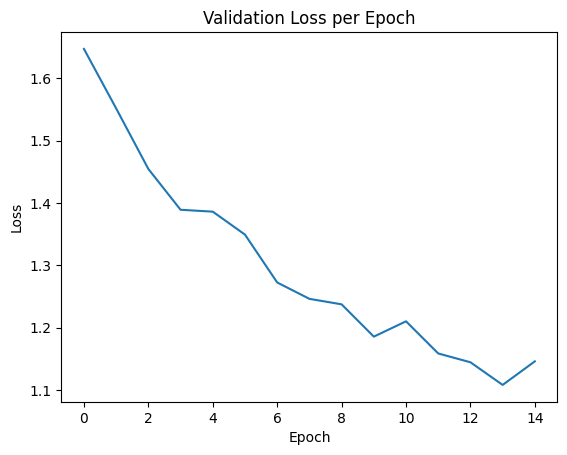

In [ ]:
plt.plot(val_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss per Epoch')
# plt.xticks(range(len(val_loss)))
plt.show()

g. Run the best model on your test set and report:

i. Overall accuracy (# of examples correctly classified / # of examples)

In [ ]:
model = Model()
model.load_state_dict(torch.load(path + 'models/model_13.params'))
model.to('cuda')
model.eval()

true_labels = []
pred_labels = []

for X, y in test_dataloader:
  X = X.to('cuda')
  y = y.to('cuda')

  pred = model(X)
  _, pred = torch.max(pred, dim=1)

  true_labels += y.tolist()
  pred_labels += pred.tolist()

# Compute accuracy
correct = 0
for i in range(len(true_labels)):
  if true_labels[i] == pred_labels[i]:
    correct += 1
accuracy = correct / len(true_labels)
print('Overall accuracy: %.4f' % accuracy)

Overall accuracy: 0.6029


ii. Accuracy per class

In [ ]:
from collections import defaultdict

accuracy_class = defaultdict(float)
count_class = defaultdict(int)

idx2names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for true_label, pred_label in zip(true_labels, pred_labels):
  if true_label == pred_label:
    accuracy_class[true_label] += 1
  count_class[true_label] += 1

for i in range(10):
  if i in accuracy_class:
    accuracy_class[i] /= count_class[i]
  else:
    # Not in true labels
    accuracy_class[i] = 0.0
  print('Accuracy for %s: %.3f' % (idx2names[i], accuracy_class[i]))

Accuracy for airplane: 0.543
Accuracy for automobile: 0.795
Accuracy for bird: 0.401
Accuracy for cat: 0.393
Accuracy for deer: 0.445
Accuracy for dog: 0.649
Accuracy for frog: 0.718
Accuracy for horse: 0.672
Accuracy for ship: 0.720
Accuracy for truck: 0.693


iii. Confusion matrix: A 10 x 10 table, where the cell at row i and column j
reports the fraction of times an example of class i was labeled by your
model as class j. Please label the rows/columns by the object class name,
not indices.

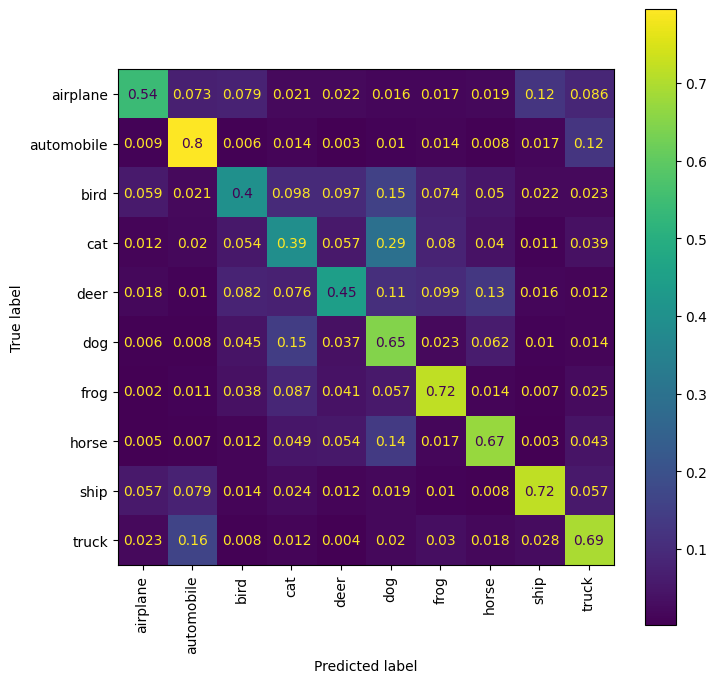

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

confusion_matrix = np.zeros((10, 10))
for true_label, pred_label in zip(true_labels, pred_labels):
    confusion_matrix[true_label][pred_label] += 1
# Normalize confusion matrix
confusion_matrix_normalized = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_normalized, display_labels=idx2names)
disp.plot(ax=ax, xticks_rotation='vertical')
plt.show()

iv. For the class on which your model has the worst accuracy (part ii), what is
the other class it is most confused with? Show 5-10 test images that your
model confused between these classes and comment on what factors
may have caused the poor performance.

Worst class: 3
Most confused with class: 5


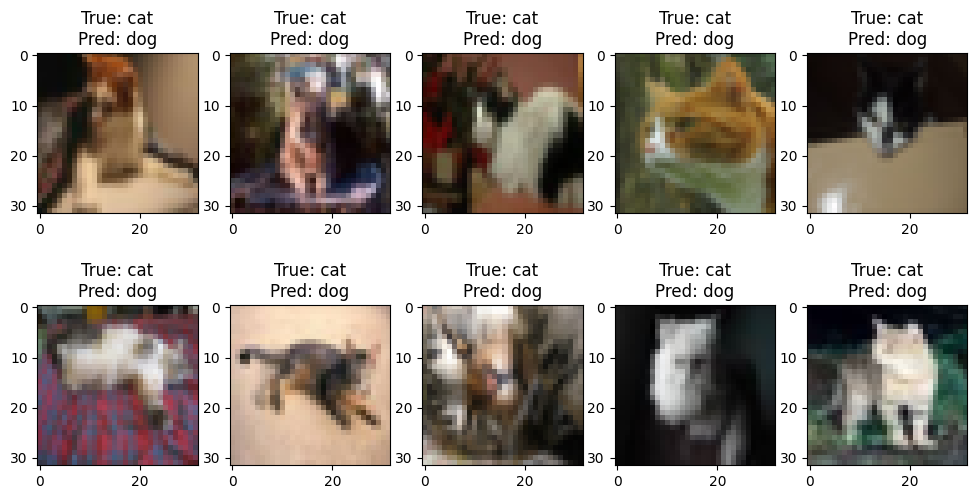

In [ ]:
# Find the worst accuracy class
worst_class = None
worst_accuracy = 1.0
for i in range(10):
  if accuracy_class[i] < worst_accuracy:
    worst_class = i
    worst_accuracy = accuracy_class[i]
print('Worst class: %d' % worst_class)

most_confused_class = None
worst_confused = 0.0
worst_total = count_class[worst_class]
for i in range(10):
  # Not including the worst class itself
  if i != worst_class:
    cur_confused = confusion_matrix_normalized[worst_class][i] / worst_total
    if cur_confused > worst_confused:
      most_confused_class = i
      worst_confused = cur_confused
print('Most confused with class: %d' % most_confused_class)

confused_images = [(i, test_dataset[i][0], test_dataset[i][1]) for i in range(len(pred_labels))
            if true_labels[i] == worst_class and pred_labels[i] == most_confused_class]

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))

for i, (idx, img, label) in zip(range(10), confused_images):
  axs[i//5, i%5].imshow(np.transpose(img, (1, 2, 0)))
  axs[i//5, i%5].set_title('True: %s\nPred: %s' % (idx2names[label], idx2names[most_confused_class]))

plt.show()

# 3.0 Adversarial Attacks

i. Implement FGSM. The function signature is in the Colab notebook.

In [ ]:
def fgsm_attack(model, image, epsilon, label):
    model.eval()

    # Requires gradients for the image tensor
    image.requires_grad = True
    output = model(image)
    loss_fn = torch.nn.CrossEntropyLoss()
    loss = loss_fn(output, label)
    loss.backward()

    # Collect the gradients of the loss w.r.t the image
    data_grad = image.grad

    # Collect the sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting it with the sign of the gradient
    perturbed_image = image + epsilon * sign_data_grad
    # perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

ii. Using a reasonable epsilon value, run FGSM on two different CIFAR-10 images. For each case, display the original image, added perturbation, final image, and class predictions of the model (see example figure below from the paper). You may have to magnify the values of the perturbed image when displaying it.

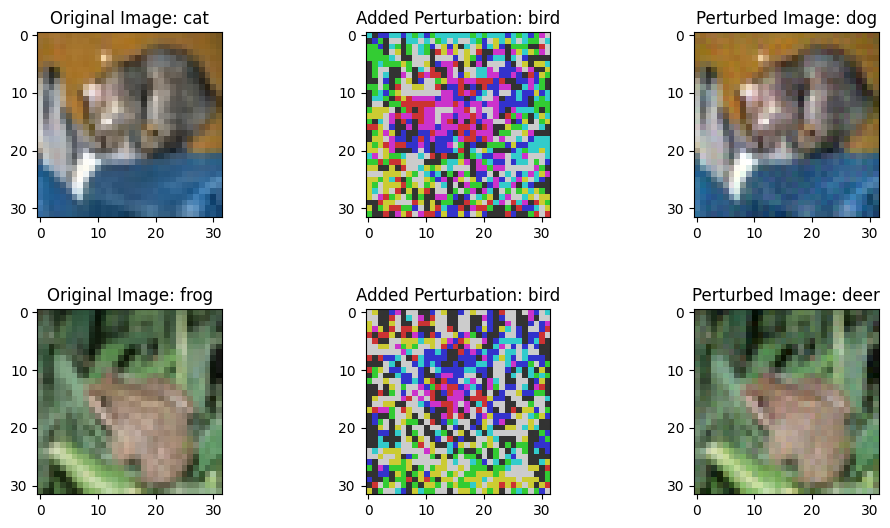

In [ ]:
import torchvision

# Set the epsilon value
epsilon = 0.02

# Select two images from the test set
dataiter = iter(test_dataset)
image1, label1 = next(dataiter)
image1 = image1.unsqueeze(0)
label1 = label1.unsqueeze(0)
next(dataiter)
next(dataiter)
next(dataiter)
image2, label2 = next(dataiter)
image2 = image2.unsqueeze(0)
label2 = label2.unsqueeze(0)

image1, image2 = image1.to('cuda'), image2.to('cuda')
label1, label2 = label1.to('cuda'), label2.to('cuda')

# Run FGSM attack on the selected images
perturbed_image1 = fgsm_attack(model, image1, epsilon, label1)
perturbed_image2 = fgsm_attack(model, image2, epsilon, label2)

with torch.no_grad():
  image_pred1 = model(image1).argmax(dim=1)

with torch.no_grad():
  image_pred2 = model(image2).argmax(dim=1)

with torch.no_grad():
  perturbed_pred1 = model(perturbed_image1).argmax(dim=1)

with torch.no_grad():
  perturbed_pred2 = model(perturbed_image2).argmax(dim=1)

with torch.no_grad():
  perturbed_1 = model(perturbed_image1 - image1).argmax(dim=1)

with torch.no_grad():
  perturbed_2 = model(perturbed_image2 - image2).argmax(dim=1)


# Display the results
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

# Image 1
axes[0, 0].imshow(np.transpose(image1.permute(0, 2, 3, 1).detach().cpu().numpy()[0], (0, 1, 2)))
axes[0, 0].set_title(f'Original Image: {idx2names[image_pred1.item()]}')
axes[0, 1].imshow((perturbed_image1 - image1).detach().permute(0, 2, 3, 1).cpu().numpy()[0] * 15.0 + 0.5)  # Scale perturbation for visualization
axes[0, 1].set_title(f'Added Perturbation: {idx2names[perturbed_1.item()]}')
axes[0, 2].imshow(np.transpose(perturbed_image1.detach().permute(0, 2, 3, 1).cpu().numpy()[0], (0, 1, 2)))  # Detach the tensor here
axes[0, 2].set_title(f'Perturbed Image: {idx2names[perturbed_pred1.item()]}')

# Image 2
axes[1, 0].imshow(np.transpose(image2.permute(0, 2, 3, 1).detach().cpu().numpy()[0], (0, 1, 2)))
axes[1, 0].set_title(f'Original Image: {idx2names[image_pred2.item()]}')
axes[1, 1].imshow((perturbed_image2 - image2).detach().permute(0, 2, 3, 1).cpu().numpy()[0] * 15.0 + 0.5)  # Scale perturbation for visualization
axes[1, 1].set_title(f'Added Perturbation: {idx2names[perturbed_2.item()]}')
axes[1, 2].imshow(np.transpose(perturbed_image2.detach().permute(0, 2, 3, 1).cpu().numpy()[0], (0, 1, 2)))  # Detach the tensor here
axes[1, 2].set_title(f'Perturbed Image: {idx2names[perturbed_pred2.item()]}')

plt.subplots_adjust(hspace=0.5)
plt.show()